# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# pd.options.display.max_rows = 300

In [3]:
universe = G10_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [4]:
s = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=130,
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=130,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=260)

# Signal 

In [23]:
## SG - Value investing in fixed income, currencies and commodities, pp16 (CM signal)
sig = total_price_usd[universe].ffill().\
          pipe(norm, 252).\
          pipe(demean_xs).\
          pipe(cap_helper, 2.5).\
          pipe(rolling_mean, 5) * -1

In [30]:
sig = spot_price_usd[universe].ffill().\
          pipe(norm, 252).pipe(zscore, 252).\
          pipe(demean_xs).\
          pipe(cap_helper, 2.5).\
          pipe(rolling_mean, 5) * -1

In [31]:
b = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = s)
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [32]:
bt_obj = b

In [33]:
get_summary(bt_obj)

Returns   : -0.02844551001725904
Vol       : 0.10961498574700428
SR        : -0.25950384268545545
Max DD    : -51.61
Hit rate  : 0.491
W | N | L : 0.49 | 0.0 | 0.51
W/L Ratio : 0.97


In [34]:
get_returns_stats(bt_obj.asset_rtn, b.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,0.40034,-0.905772,-1.409462,0.670283,0.234542,-0.223211,-1.005063,0.587668,-0.784669
sharpe,0.112689,-0.230019,-0.557336,0.193984,0.054307,-0.071889,-0.389797,0.217008,-0.243104
dollar_sharpe,0.100359,-0.26089,-0.57238,0.162677,0.030328,-0.089755,-0.408561,0.21226,-0.260248
trade_sharpe,0.112689,-0.230019,-0.557336,0.193984,0.054307,-0.071889,-0.389797,0.217008,-0.243104
long_sharpe,-0.050694,-0.489937,-0.297436,0.41792,0.314191,-0.223952,-0.324952,0.153215,0.134579
short_sharpe,0.288825,0.088835,-0.874502,0.09067,-0.216179,0.061519,-0.507175,0.301004,-0.530613
sortino,0.065563,-0.136241,-0.280912,0.102103,0.029798,-0.041585,-0.207325,0.120362,-0.115111
max_drawdown,-11.059699,-26.817726,-27.863342,-16.003157,-26.419674,-14.079457,-17.688318,-11.78277,-29.735673
max_drawdown_start,2002-06-21,2003-02-10,2005-04-20,2013-01-09,2012-09-27,2006-01-13,2002-06-12,2003-06-13,2004-04-23
max_drawdown_end,2007-08-16,2010-04-14,2015-08-24,2016-10-11,2013-06-14,2007-09-05,2016-12-30,2010-01-11,2015-11-27


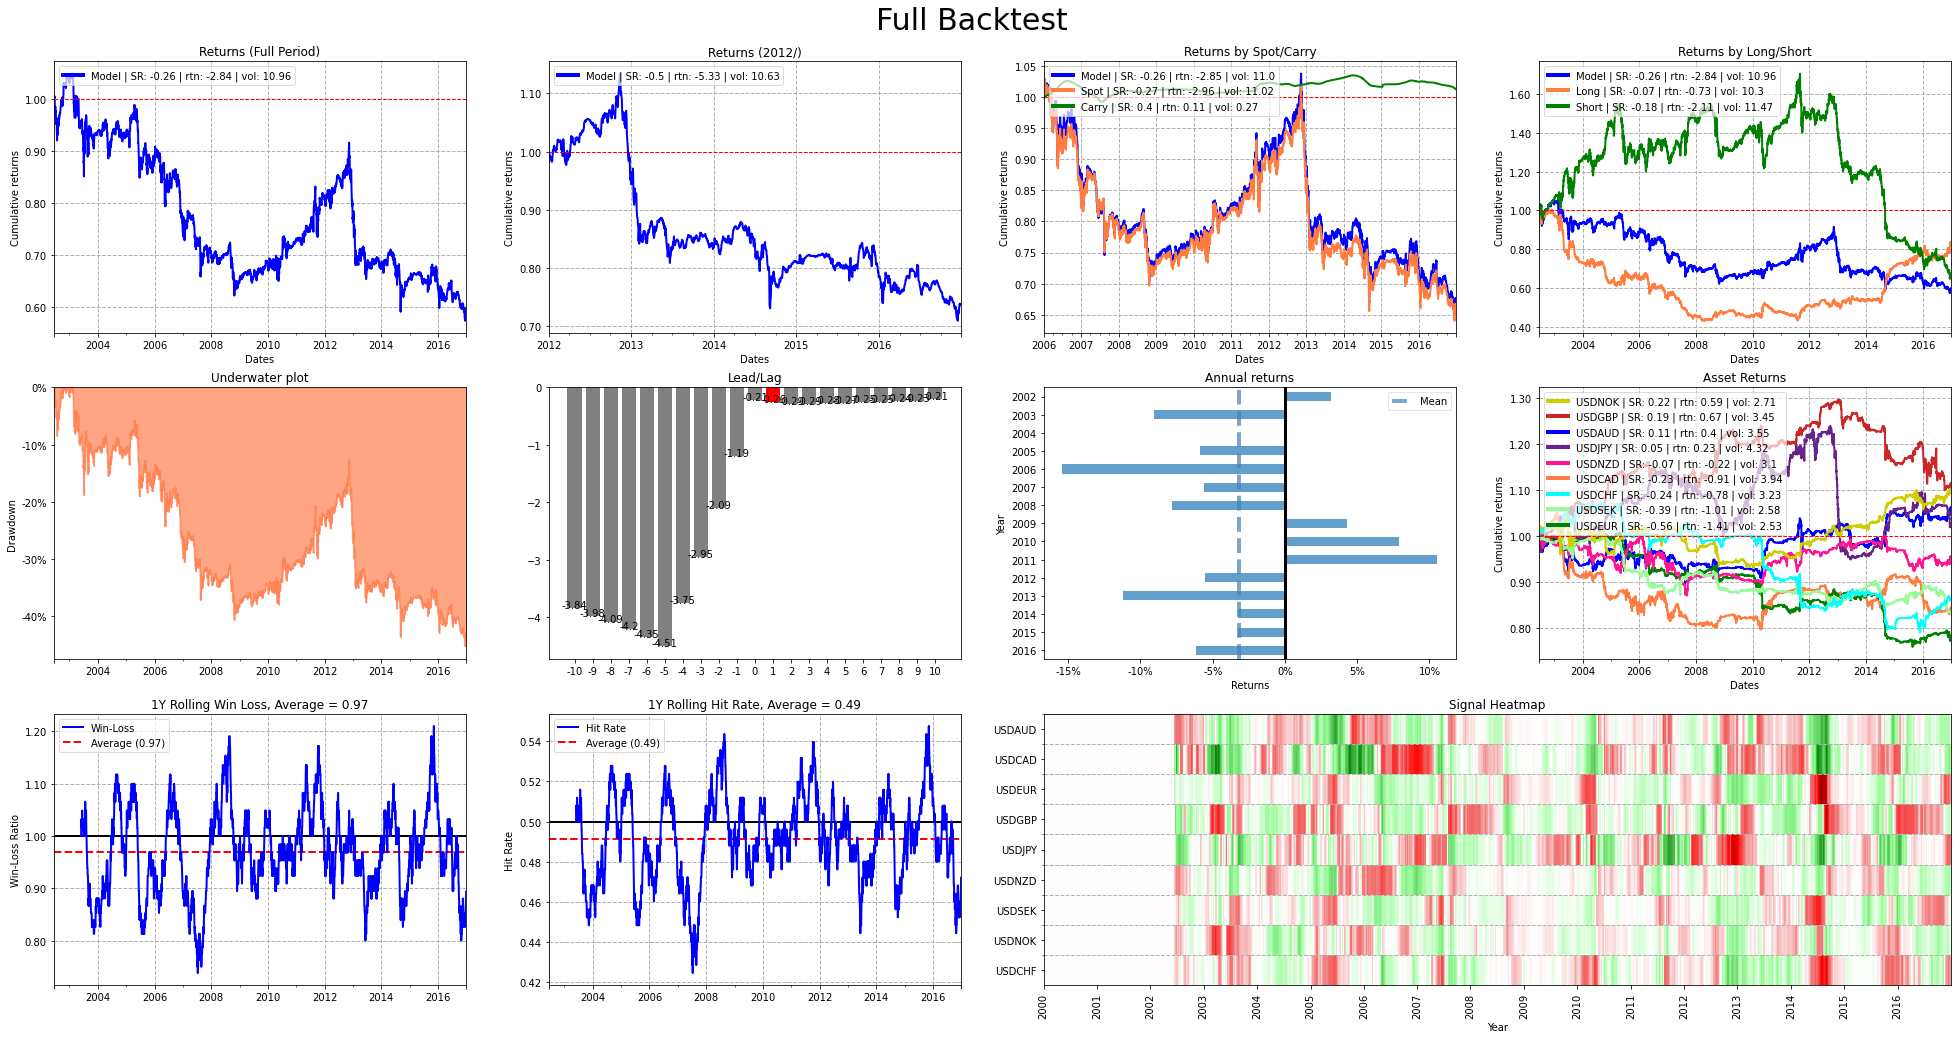

In [35]:
plot_bt(bt_obj)

In [ ]:
pf.plot_monthly_returns_dist(bt_obj.model_rtn)

In [ ]:
gs = GridSpec(nrows = 2, ncols = 2)
fig = plt.figure(figsize=(20, 15))
fig.suptitle(t="Full Backtest", fontsize=30, y=.925)

fig.add_subplot(gs[0]).set_label(gen_plot_rtn(bt_obj.model_rtn, main = "Returns (Full Period)"))
fig.add_subplot(gs[1]).set_label(gen_rtn_asset(bt_obj))
fig.add_subplot(gs[2]).set_label(pf.plot_drawdown_underwater(bt_obj.model_rtn))
fig.add_subplot(gs[3]).set_label(gen_rtn_longshort(bt_obj))

In [ ]:
# gen_rtn_longshort(bt_obj)
# gen_rtn_component(bt_obj, spot_rtns, carry_rtns)
# gen_leadlag(b, nlag=20)
# gen_rolling_hitrate(bt_obj.model_rtn)
# gen_rolling_winloss(bt_obj.model_rtn)
# pf.plot_monthly_returns_dist(bt_obj.model_rtn)
# pf.plot_annual_returns(bt_obj.model_rtn)
# gen_signal(bt_obj)
# gen_rtn_asset(bt_obj)
# gen_plot_rtn(bt_obj.model_rtn["2012":])
# gen_rolling_sharpe(bt_obj.model_rtn)
# gen_rtn_col_component(bt_obj, spot_rtns, carry_rtns)
# gen_rtn_col_longshort(bt_obj)

In [ ]:
def band_filter(series):
  return series.applymap(lambda x: 1 if x < -1.5 else -1 if x > 1.5 else 0)

def hold_position(series):
  tmp = np.sign(series).diff()
  return pd.Series([np.nan if y == 0 else x for x,y in zip(series, tmp.diff())], index = tmp.index).ffill()

binary = spot_returns.pipe(zscore, 252*5).pipe(band_filter)
mag = abs(spot_returns.pipe(zscore, 252*5)) * binary
sig = mag.apply(hold_position)